In [84]:
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import re
import plotly.express as px

import sys
sys.path.append('src/')
from pint import UnitRegistry

from webscraper import parse_url_info, drop_duplicate_product_urls

In [85]:

def parse_volume_string(input_string):
    # thank you chatgpt <3
    #pattern = r"(?<!\d)(\d+(?:\.\d+)?)\s*([a-zA-Z]+)(?=\s|$)"

    pattern = r'(\d+(\.\d+)?)\s*(\w+)\s+(\d+(\.\d+)?)\s*(\w+)\s*(.*)'
    matches = re.search(pattern, input_string)
    if matches:
        amount1 = matches.group(1)
        unit1 = matches.group(3)
        amount2 = matches.group(4)
        unit2 = matches.group(6)
        trailing_text = matches.group(7).strip()
        return amount1, unit1, amount2, unit2, trailing_text
    return None

def parse_single_volume(input_string):
    pattern = r'\s*(\d+(\.\d*)?|\.\d+)\s*(\w+)\s*'
    matches = re.match(pattern, input_string)
    if matches:
        amount = matches.group(1)
        unit = matches.group(3)
        return amount, unit
    return None

def shorthand_amt_conversion(value):
    if value:
        return value.replace(".","").replace("K","00").replace("M","000000")
    return None



In [86]:
product_files = glob.glob("data/products/*")
products = []
for product_file in product_files:
    with open(product_file) as file:
        products.append(pd.json_normalize(json.loads(file.read())))
        
df_products = pd.concat(products, axis=0)
df_products = df_products[df_products['product_name'].notnull()]
df_products = df_products.reset_index(drop=True).reset_index().rename(columns={'index':'internal_product_id'})

In [87]:
product_options = []
for product in df_products.iterrows():
    url = product[1]['url']
    df_options = pd.json_normalize(product[1]['options'])
    df_options['url'] = url
    product_options.append(df_options)
    
df_products = df_products.merge(pd.concat(product_options), how='left', on='url')

In [88]:
# string col to lower
cols_to_lower = ['product_name', 'brand_name', 'swatch_group', 'size', 'name']
df_products[cols_to_lower] = df_products[cols_to_lower].apply(lambda x: x.str.lower())

#### product ratings
df_products['rating'] = df_products['rating'].str.replace("width:","")
df_products['rating'] = df_products['rating'].str.replace("%","")
df_products['rating'] = df_products['rating'].astype(float)
df_products['rating'] = df_products['rating']/100 * 5

####
df_products['n_loves'] = df_products['n_loves'].apply(shorthand_amt_conversion)
df_products['n_loves'] = df_products['n_loves'].astype(float)

####
df_products['product_reviews'] = df_products['product_reviews'].apply(shorthand_amt_conversion)
df_products['product_reviews'] = df_products['product_reviews'].astype(float)

####
df_products['price'] = df_products['price'].str.replace("$","")
df_products['price'] = df_products['price'].astype(float)

####
df_products['out_of_stock'] = df_products['name'].str.contains('out of stock')
df_products['limited_edition'] = df_products['name'].str.contains('limited edition')
df_products['new_product'] = df_products['name'].str.contains('new')
df_products['few_left'] = df_products['name'].str.contains('only a few left')
df_products['sale'] = df_products['name'].str.contains('sale')
df_products['refill'] = df_products['name'].str.contains('refill')

####
df_products['sku'] = df_products['sku'].str.replace("Item ","")
####
df_products['url_path'], df_products['url_sku'], df_products['url_params'] =  df_products['url'].apply(parse_url_info).str
df_products = df_products.drop_duplicates(subset=['brand_name','product_name','url_path', 'sku','price'], keep='last')
####

df_products.loc[df_products['size'].isna(), 'size'] = df_products['name']
df_products.loc[df_products['size']==df_products['name'],'name'] = None


misc_text = {
    "out of stock":"",
    "limited edition":"",
    "new":"",
    "only a few left":"",
    "sale":"",
    "size":"",
    "refill":"",
    "color":"",
    ":":"",
    "-":"",
    "mini":"",
    " oz.":" oz",
    "/":" ",
    r'\s+': ' '
}


# def clean_size_info(info_str):
#     return 


def series_replace(df, ids):
    for key in ids.keys():
        df['size'] = df['size'].str.replace(key, ids[key], regex=True)
    return df

df_products = series_replace(df_products, misc_text)
print(misc_text)
df_products['size'] = df_products['size'].fillna("")
df_products['size'] = df_products['size'].str.strip()
df_products.loc[df_products['size'].str[0]=='.', 'size'] = "0"+df_products['size']
df_products['size'] = df_products['size'].str.replace(" ."," 0.", regex=False)
df_products['size'] = df_products['size'].str.replace("fl oz"," floz", regex=False)
df_products['size'] = df_products['size'].str.replace("fl. oz"," floz", regex=False)

df_products.loc[df_products['size'].str.contains('x'),'product_multiplier'] = df_products['size'].apply(lambda x : x.split("x"))
df_products.loc[df_products['product_multiplier'].notnull(), 'multiplier'] = df_products['product_multiplier'].str[0]
df_products.loc[df_products['product_multiplier'].notnull(), 'size'] = df_products['product_multiplier'].str[1]

df_products['amount_a'], df_products['unit_a'], df_products['amount_b'], df_products['unit_b'], df_products['misc_info'] = df_products['size'].apply(parse_volume_string).str
df_products[['amount_a','amount_b']] = df_products[['amount_a','amount_b']].astype(float)

df_products['amount_single'], df_products['unit_single'] = df_products[df_products['amount_a'].isna()]['size'].apply(parse_single_volume).str

df_products['amount_single']= df_products['amount_single'].astype(float)

df_products.loc[df_products['amount_a'].isna(), 'amount_a'] = df_products['amount_single']
df_products.loc[df_products['amount_a'].isna(), 'unit_a'] = df_products['unit_single']

df_products = df_products.drop(['amount_single','unit_single'],axis=1)


df_products = df_products[df_products['unit_a'].isin(['floz','oz'])]
df_products = df_products[df_products['unit_b'].isin(['g','ml'])]
# df_products.loc[(df_products['unit_a']=='oz') & (df_products['unit_b']=='ml'),'unit_a']='floz'
df_products.loc[(df_products['unit_a']=='fl'),'unit_a']='floz'

####
df_products['categories'] = df_products['categories'].fillna('   ')
df_products['lvl_0_cat'], df_products['lvl_1_cat'], df_products['lvl_2_cat'] = df_products['categories'].str
df_products['lvl_2_cat'] = df_products['lvl_2_cat'].fillna("")
df_products = df_products[~df_products['lvl_2_cat'].str.contains("Sets")]

#### swatch_group
df_products['swatch_details'] = df_products['swatch_group'].str.split(" - ").str[0]
df_products['swatch_group'] = df_products['swatch_group'].str.split(" - ").str[-1]


df_products['unit_price'] = df_products['price'] / df_products['amount_a']

solid_products = df_products[(df_products['unit_a']=='oz')]

solid_products = solid_products.groupby(['brand_name','product_name','swatch_group'], as_index=False).agg({
    'sku':['unique','count'],
    'rating':'first',
    'product_reviews':'first',
    'price':['first','unique','nunique'],
    'size':'first',
    'name':'nunique',
    'amount_a':'first',
    'unit_a':'first',
    'amount_b':'first',
    'unit_b':'first',
    'lvl_0_cat':'first',
    'lvl_1_cat':'first',
    'lvl_2_cat':'first'
})
solid_products.columns = ['_'.join(x) for x in solid_products.columns]


/var/folders/3_/49qq58ns2r11fnng7d9pbd0w0000gn/T/ipykernel_18276/3060589603.py:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_products['price'] = df_products['price'].str.replace("$","")
/var/folders/3_/49qq58ns2r11fnng7d9pbd0w0000gn/T/ipykernel_18276/3060589603.py:34: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df_products['url_path'], df_products['url_sku'], df_products['url_params'] =  df_products['url'].apply(parse_url_info).str


{'out of stock': '', 'limited edition': '', 'new': '', 'only a few left': '', 'sale': '', 'size': '', 'refill': '', 'color': '', ':': '', '-': '', 'mini': '', ' oz.': ' oz', '/': ' ', '\\s+': ' '}


/var/folders/3_/49qq58ns2r11fnng7d9pbd0w0000gn/T/ipykernel_18276/3060589603.py:82: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df_products['amount_a'], df_products['unit_a'], df_products['amount_b'], df_products['unit_b'], df_products['misc_info'] = df_products['size'].apply(parse_volume_string).str
/var/folders/3_/49qq58ns2r11fnng7d9pbd0w0000gn/T/ipykernel_18276/3060589603.py:85: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df_products['amount_single'], df_products['unit_single'] = df_products[df_products['amount_a'].isna()]['size'].apply(parse_single_volume).str
/var/folders/3_/49qq58ns2r11fnng7d9pbd0w0000gn/T/ipykernel_18276/3060589603.py:102: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df_products['lvl_0_cat'], df_products['lvl_1_cat'], df_products['lvl_2_cat'] = df_products['categories'].str


In [89]:
df_products[(df_products['unit_a']=='oz') & (df_products['unit_b']=='oz')]

,internal_product_id,url,product_name,brand_name,options,rating,product_reviews,ingredients,n_loves,categories,swatch_group,size,name,price,sku,out_of_stock,limited_edition,new_product,few_left,sale,refill,url_path,url_sku,url_params,product_multiplier,multiplier,amount_a,unit_a,amount_b,unit_b,misc_info,lvl_0_cat,lvl_1_cat,lvl_2_cat,swatch_details,unit_price


In [79]:
df_products.groupby(['unit_a','unit_b'])['internal_product_id'].count().head(100)

unit_a  unit_b
floz    g             1
        ml          335
oz      g          6073
        ml        11368
Name: internal_product_id, dtype: int64

In [80]:
# def conv_solid(row):

#     return ureg(str(row['amount_a'])+" "+row['unit_a']).to(row['unit_b'])

# solid_products['a_conv'] = solid_products.apply(conv_solid, axis=1)
# solid_products['a_conv_magnitude'] = solid_products['a_conv'].apply(lambda x : x.magnitude)

In [102]:

solid_products.lvl_2_cat_first.value_counts()

Perfume                       767
Moisturizers                  424
                              392
Face Serums                   343
Shampoo                       243
Face Wash & Cleansers         226
Hair Styling Products         219
Rollerballs & Travel Size     214
Conditioner                   196
Body Lotions & Body Oils      179
Mascara                       176
Candles                       161
Cologne                       159
Lipstick                      156
Setting Spray & Powder        151
Eye Creams & Treatments       146
Foundation                    131
Face Primer                   126
Face Masks                    123
Eyebrow                       114
Eyeliner                      101
Blush                         100
Hair Masks                     98
Highlighter                    94
Concealer                      87
Scalp Treatments               81
Toners                         72
Mists & Essences               70
Lip Gloss                      66
Face Oils     

In [100]:

# df_products_tree = df_products.groupby(['lvl_0_cat', 'lvl_1_cat', 'lvl_2_cat','brand_name'], as_index=False)['internal_product_id'].count()
# fig = px.treemap(df_products_tree, path=[px.Constant("all"), 'lvl_0_cat', 'lvl_1_cat', 'lvl_2_cat','brand_name'], values='internal_product_id')
# fig.update_traces(root_color="lightgrey")
# fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
# fig.show()

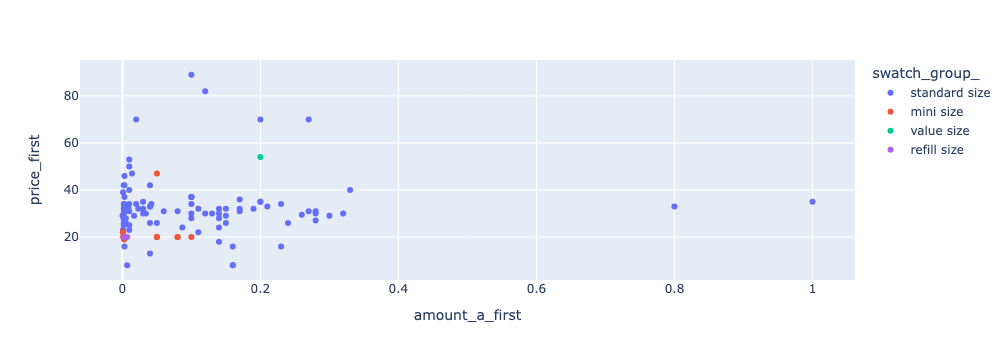

In [103]:
fig = px.scatter(solid_products[solid_products['lvl_2_cat_first']=='Eyebrow'], x="amount_a_first", y="price_first", color="swatch_group_", hover_data=['brand_name_', 'product_name_'])
fig.show()

In [359]:
solid_products['unit_price'] = solid_products['amount_a_first']/solid_products['price_first']#.hist()

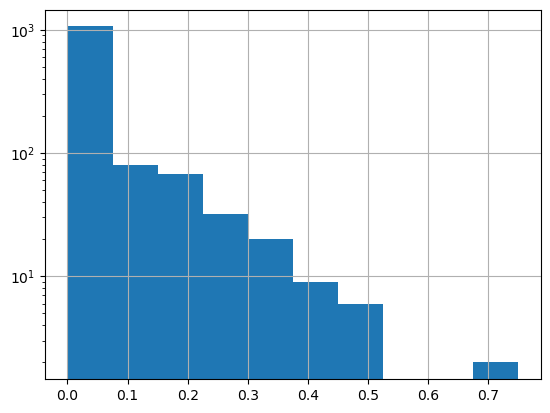

In [360]:
solid_products['unit_price'].hist()
plt.yscale('log')

In [423]:
# solid_products.sort_values(by='unit_price',ascending=False)

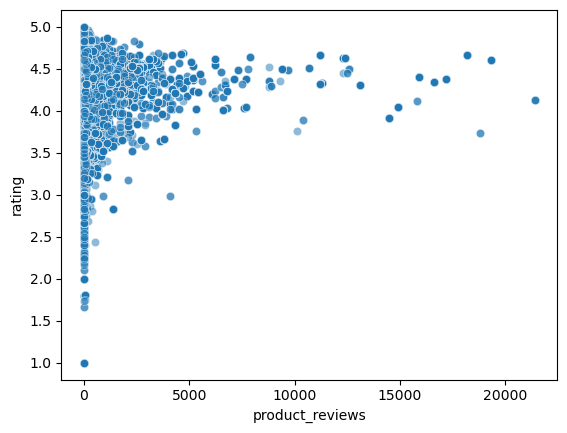

,internal_product_id,url,product_name,brand_name,options,rating,product_reviews,ingredients,n_loves,categories,swatch_group,size,name,price,sku,out_of_stock,limited_edition,new_product,few_left,sale,refill,url_path,url_sku,url_params,product_multiplier,multiplier,amount_a,unit_a,amount_b,unit_b,misc_info,lvl_0_cat,lvl_1_cat,lvl_2_cat,swatch_details,unit_price
9586,3621,https://www.sephora.com/ca/en/product/better-t...,better than sex volumizing & lengthening water...,too faced,"[{'swatch_group': 'Standard size', 'size': Non...",2.9823,4100.0,"Isododecane, Paraffin, VP/Eicosene Copolymer, ...",116700.0,"[Makeup, Eye, Mascara]",standard size,standard black 0.27 oz 8 ml,None,37.0,1809193,False,False,False,False,False,False,/ca/en/product/better-than-sex-waterproof-masc...,1809193,"{'skuId': ['1809193'], 'icid2': ['products gri...",NaN,NaN,0.27,oz,8.0,ml,,Makeup,Eye,Mascara,standard size,137.037037
9587,3621,https://www.sephora.com/ca/en/product/better-t...,better than sex volumizing & lengthening water...,too faced,"[{'swatch_group': 'Standard size', 'size': Non...",2.9823,4100.0,"Isododecane, Paraffin, VP/Eicosene Copolymer, ...",116700.0,"[Makeup, Eye, Mascara]",mini size,black 0.17 oz 5 ml,None,21.0,1834167,False,False,False,False,False,False,/ca/en/product/better-than-sex-waterproof-masc...,1809193,"{'skuId': ['1809193'], 'icid2': ['products gri...",NaN,NaN,0.17,oz,5.0,ml,,Makeup,Eye,Mascara,mini size,123.529412


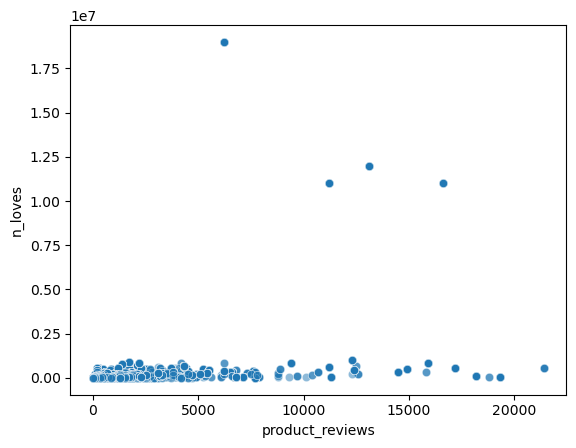

array(['soft pinch liquid blush',
       'lip sleeping mask intense hydration with vitamin c',
       'radiant creamy concealer', 'cream lip stain liquid lipstick'],
      dtype=object)

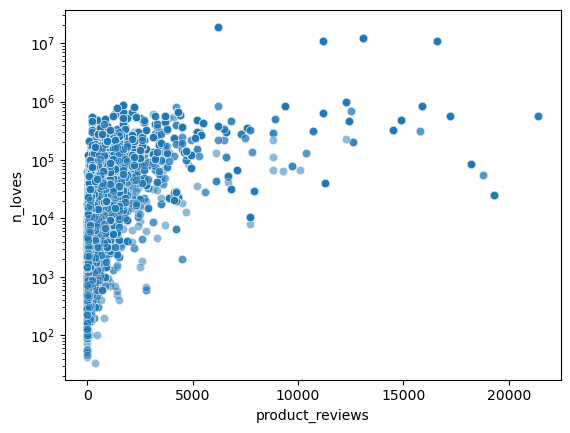

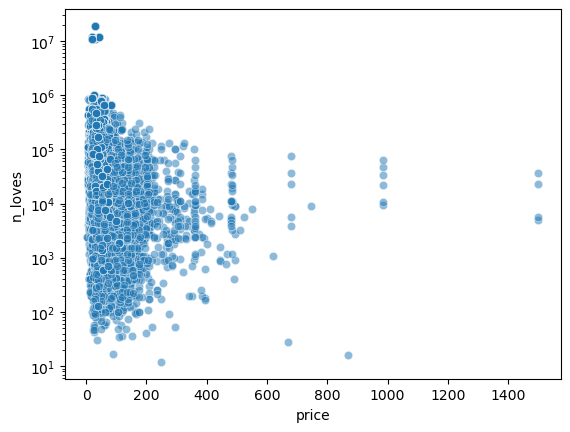

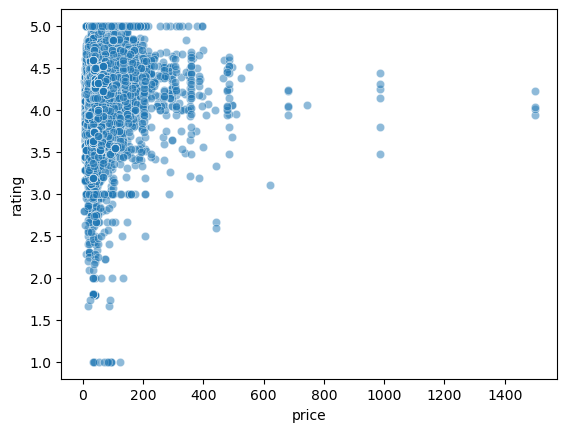

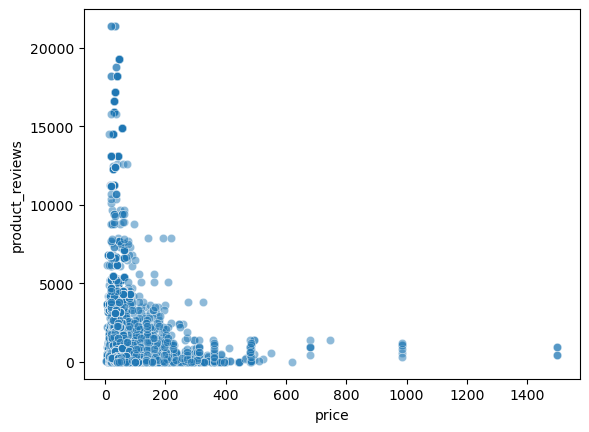

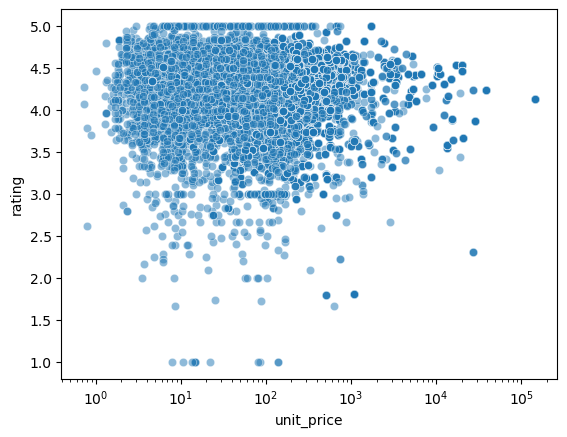

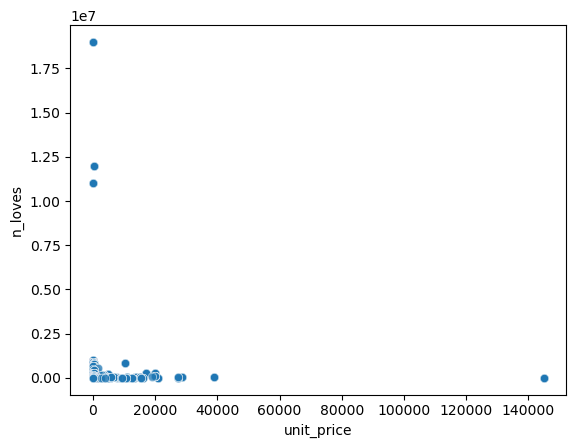

In [106]:
# df_products
# EDA - what is the distribution of product reviews
# scatter reviews v ratings

sns.scatterplot(data=df_products, x="product_reviews", y="rating", alpha=0.5)
plt.show()
# how many products have no reviews?
# interesting outliers - looked at reviews, truly bad
display(df_products[(df_products['product_reviews']>4000) & (df_products['rating']<3.2)])


# scattr review v loves
# the handful of outliers are so interesting
# was there a promotion to add these to loves list?
sns.scatterplot(data=df_products, x="product_reviews", y="n_loves", alpha=0.5)
plt.show()
display(df_products[(df_products['n_loves']>1500000)]['product_name'].unique())
sns.scatterplot(data=df_products, x="product_reviews", y="n_loves", alpha=0.5)
plt.yscale('log')
plt.show()
# scatter n loves v price 
sns.scatterplot(data=df_products, x="price", y="n_loves", alpha=0.5)
plt.yscale('log')
plt.show()


sns.scatterplot(data=df_products, x="price", y="rating", alpha=0.5)
plt.show()

sns.scatterplot(data=df_products, x="price", y="product_reviews", alpha=0.5)
plt.show()

sns.scatterplot(data=df_products[df_products['unit_a']=='oz'], x="unit_price", y="rating", alpha=0.5)
plt.xscale('log')
plt.show()

sns.scatterplot(data=df_products[df_products['unit_a']=='oz'], x="unit_price", y="n_loves", alpha=0.5)
plt.show()

In [91]:
df_products.sort_values(by='unit_price', ascending=False)

,internal_product_id,url,product_name,brand_name,options,rating,product_reviews,ingredients,n_loves,categories,swatch_group,size,name,price,sku,out_of_stock,limited_edition,new_product,few_left,sale,refill,url_path,url_sku,url_params,product_multiplier,multiplier,amount_a,unit_a,amount_b,unit_b,misc_info,lvl_0_cat,lvl_1_cat,lvl_2_cat,swatch_details,unit_price
14331,4944,https://www.sephora.com/ca/en/product/the-edge...,the edge precision eyebrow pencil,haus labs by lady gaga,[{'swatch_group': 'Natural finish - Standard s...,4.1333,30.0,"-Micronized Pigments: Deliver creamy, even col...",9800.0,"[Makeup, Eye, Eyebrow]",standard size,0.0002 oz 0.07 g,color: noir - neutral undertone | recommended ...,29.0,2572105,False,False,False,False,False,False,/ca/en/product/the-edge-precision-eyebrow-penc...,2572055,"{'skuId': ['2572055'], 'icid2': ['products gri...",NaN,NaN,0.0002,oz,0.07,g,,Makeup,Eye,Eyebrow,natural finish,145000.000000
14334,4944,https://www.sephora.com/ca/en/product/the-edge...,the edge precision eyebrow pencil,haus labs by lady gaga,[{'swatch_group': 'Natural finish - Standard s...,4.1333,30.0,"-Micronized Pigments: Deliver creamy, even col...",9800.0,"[Makeup, Eye, Eyebrow]",standard size,0.0002 oz 0.07 g,color: cinnamon - warm undertone | recommended...,29.0,2572014,False,False,False,False,False,False,/ca/en/product/the-edge-precision-eyebrow-penc...,2572055,"{'skuId': ['2572055'], 'icid2': ['products gri...",NaN,NaN,0.0002,oz,0.07,g,,Makeup,Eye,Eyebrow,natural finish,145000.000000
14332,4944,https://www.sephora.com/ca/en/product/the-edge...,the edge precision eyebrow pencil,haus labs by lady gaga,[{'swatch_group': 'Natural finish - Standard s...,4.1333,30.0,"-Micronized Pigments: Deliver creamy, even col...",9800.0,"[Makeup, Eye, Eyebrow]",standard size,0.0002 oz 0.07 g,color: auburn - neutral undertone | recommende...,29.0,2572022,False,False,False,False,False,False,/ca/en/product/the-edge-precision-eyebrow-penc...,2572055,"{'skuId': ['2572055'], 'icid2': ['products gri...",NaN,NaN,0.0002,oz,0.07,g,,Makeup,Eye,Eyebrow,natural finish,145000.000000
14322,4944,https://www.sephora.com/ca/en/product/the-edge...,the edge precision eyebrow pencil,haus labs by lady gaga,[{'swatch_group': 'Natural finish - Standard s...,4.1333,30.0,"-Micronized Pigments: Deliver creamy, even col...",9800.0,"[Makeup, Eye, Eyebrow]",standard size,0.0002 oz 0.07 g,color: soft blonde - neutral undertone | recom...,29.0,2571982,False,False,False,False,False,False,/ca/en/product/the-edge-precision-eyebrow-penc...,2572055,"{'skuId': ['2572055'], 'icid2': ['products gri...",NaN,NaN,0.0002,oz,0.07,g,,Makeup,Eye,Eyebrow,natural finish,145000.000000
14323,4944,https://www.sephora.com/ca/en/product/the-edge...,the edge precision eyebrow pencil,haus labs by lady gaga,[{'swatch_group': 'Natural finish - Standard s...,4.1333,30.0,"-Micronized Pigments: Deliver creamy, even col...",9800.0,"[Makeup, Eye, Eyebrow]",standard size,0.0002 oz 0.07 g,color: medium blonde - neutral undertone | rec...,29.0,2571990,False,False,False,False,False,False,/ca/en/product/the-edge-precision-eyebrow-penc...,2572055,"{'skuId': ['2572055'], 'icid2': ['products gri...",NaN,NaN,0.0002,oz,0.07,g,,Makeup,Eye,Eyebrow,natural finish,145000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16268,5584,https://www.sephora.com/ca/en/product/sephora-...,moisturizing body lotion,sephora collection,"[{'swatch_group': 'Standard size', 'size': 'Si...",3.7009,107.0,"Aqua (Water), Glycerin, Dimethicone, Isopropyl...",27700.0,"[Bath & Body, Body Moisturizers, Body Lotions ...",standard size,6.76 oz 200 ml,scent: monoisale,6.0,2400695,False,False,False,False,True,False,/ca/en/product/sephora-collection-moisturizing...,2400695,"{'skuId': ['2400695'], 'icid2': ['products gri...",NaN,NaN,6.7600,oz,200.00,ml,,Bath & Body,Body Moisturizers,Body Lotions & Body Oils,standard size,0.887574
15567,54

## Swatch group comparisons

In [197]:
df = df_products[df_products['lvl_2_cat']=='Mascara'].groupby(['brand_name','product_name','swatch_group','unit_a'], as_index=False).agg({
    'internal_product_id':'count',
    'unit_price':'mean',
    'price':'mean',
    'amount_a':'mean'
})


In [198]:
df = df[df.groupby(['brand_name','product_name','unit_a'])['swatch_group'].transform(lambda x : x.nunique()>1)]

df['full_product'] = df['brand_name']+' '+ df['product_name']
df = df.pivot(index='full_product', columns='swatch_group', values='unit_price') # ['unit_a',]
df = df.reset_index()

In [199]:
df = df[['full_product','mini size','standard size']]

In [200]:
df = df.set_index('full_product').stack('swatch_group').reset_index().rename(columns={0:'unit_price'}).head(30)

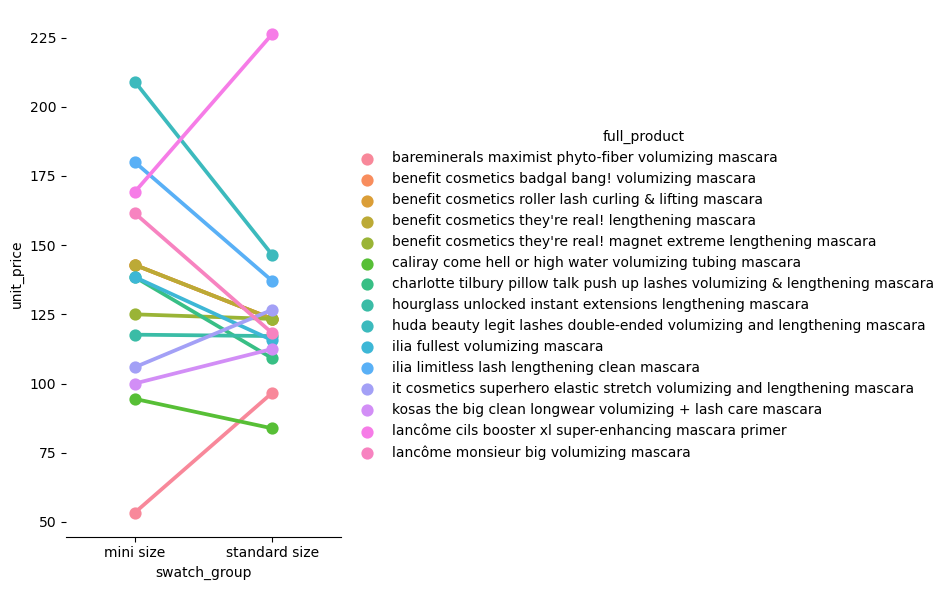

In [201]:

# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(
    data=df, x="swatch_group", y="unit_price", hue="full_product",
    capsize=.2, #palette="YlGnBu_d",
    kind="point", height=6, aspect=.75,
)
g.despine(left=True)

In [ ]:
# in bare minerals - mini size == standard